In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt
import scipy.stats as stats

from data_processing import *

%load_ext autoreload
%autoreload 2


In [2]:
X, y = get_training_data()
X_testing = get_testing_data()
#Unnamed: 0 is the Id of the row, we can drop it
X = X.drop('Unnamed: 0', axis=1 )

x_testing_id = X_testing['Unnamed: 0']
X_testing = X_testing.drop('Unnamed: 0', axis=1 )
# Unnamed: 0 is the Id of the row, we can drop it
y = y.drop(columns=['Unnamed: 0'])  # If the first column is labeled as 'Unnamed: 0'


### Data exploration

In [ ]:
print('Number of elements :', len(X))
print('Number of features :', len(X.columns))

In [ ]:
print('len(y):', len(y))

In [ ]:
X.info()

In [ ]:
X.isnull().sum()

In [3]:
unique_values = {}
for col in X.columns:
    unique_values[col] = X[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()

,unique value count
HighBP,2
HighChol,2
CholCheck,2
BMI,182669
Smoker,2
Stroke,2
HeartDiseaseorAttack,2
PhysActivity,2
Fruits,2
Veggies,2


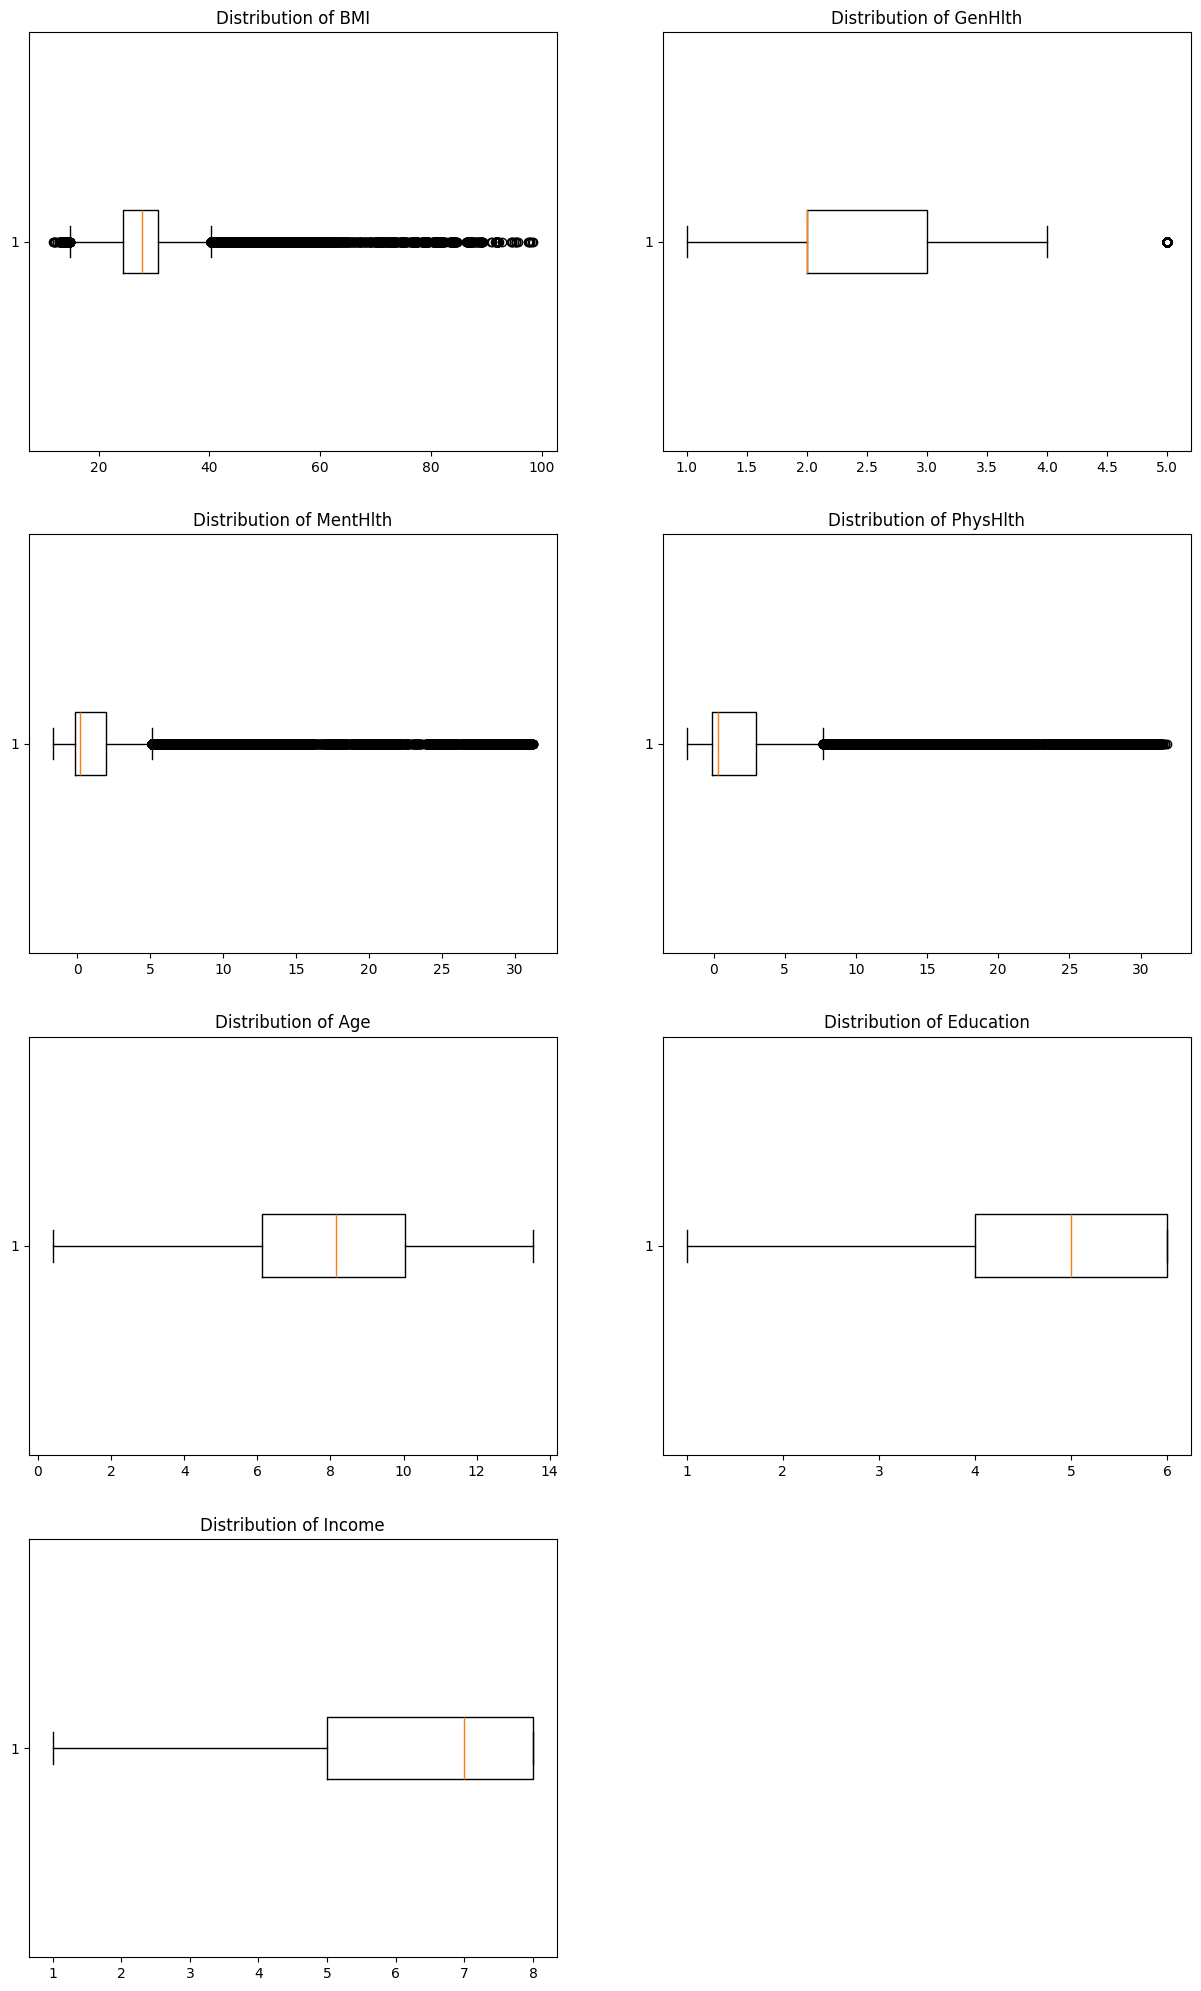

In [4]:
plt.figure(figsize = (15,25))
for i,col in enumerate(['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age','Education', 'Income']):
    plt.subplot(4,2,i+1)
    plt.title('Distribution of '+col)
    plt.boxplot(x = col, data = X, vert=False)
plt.show()

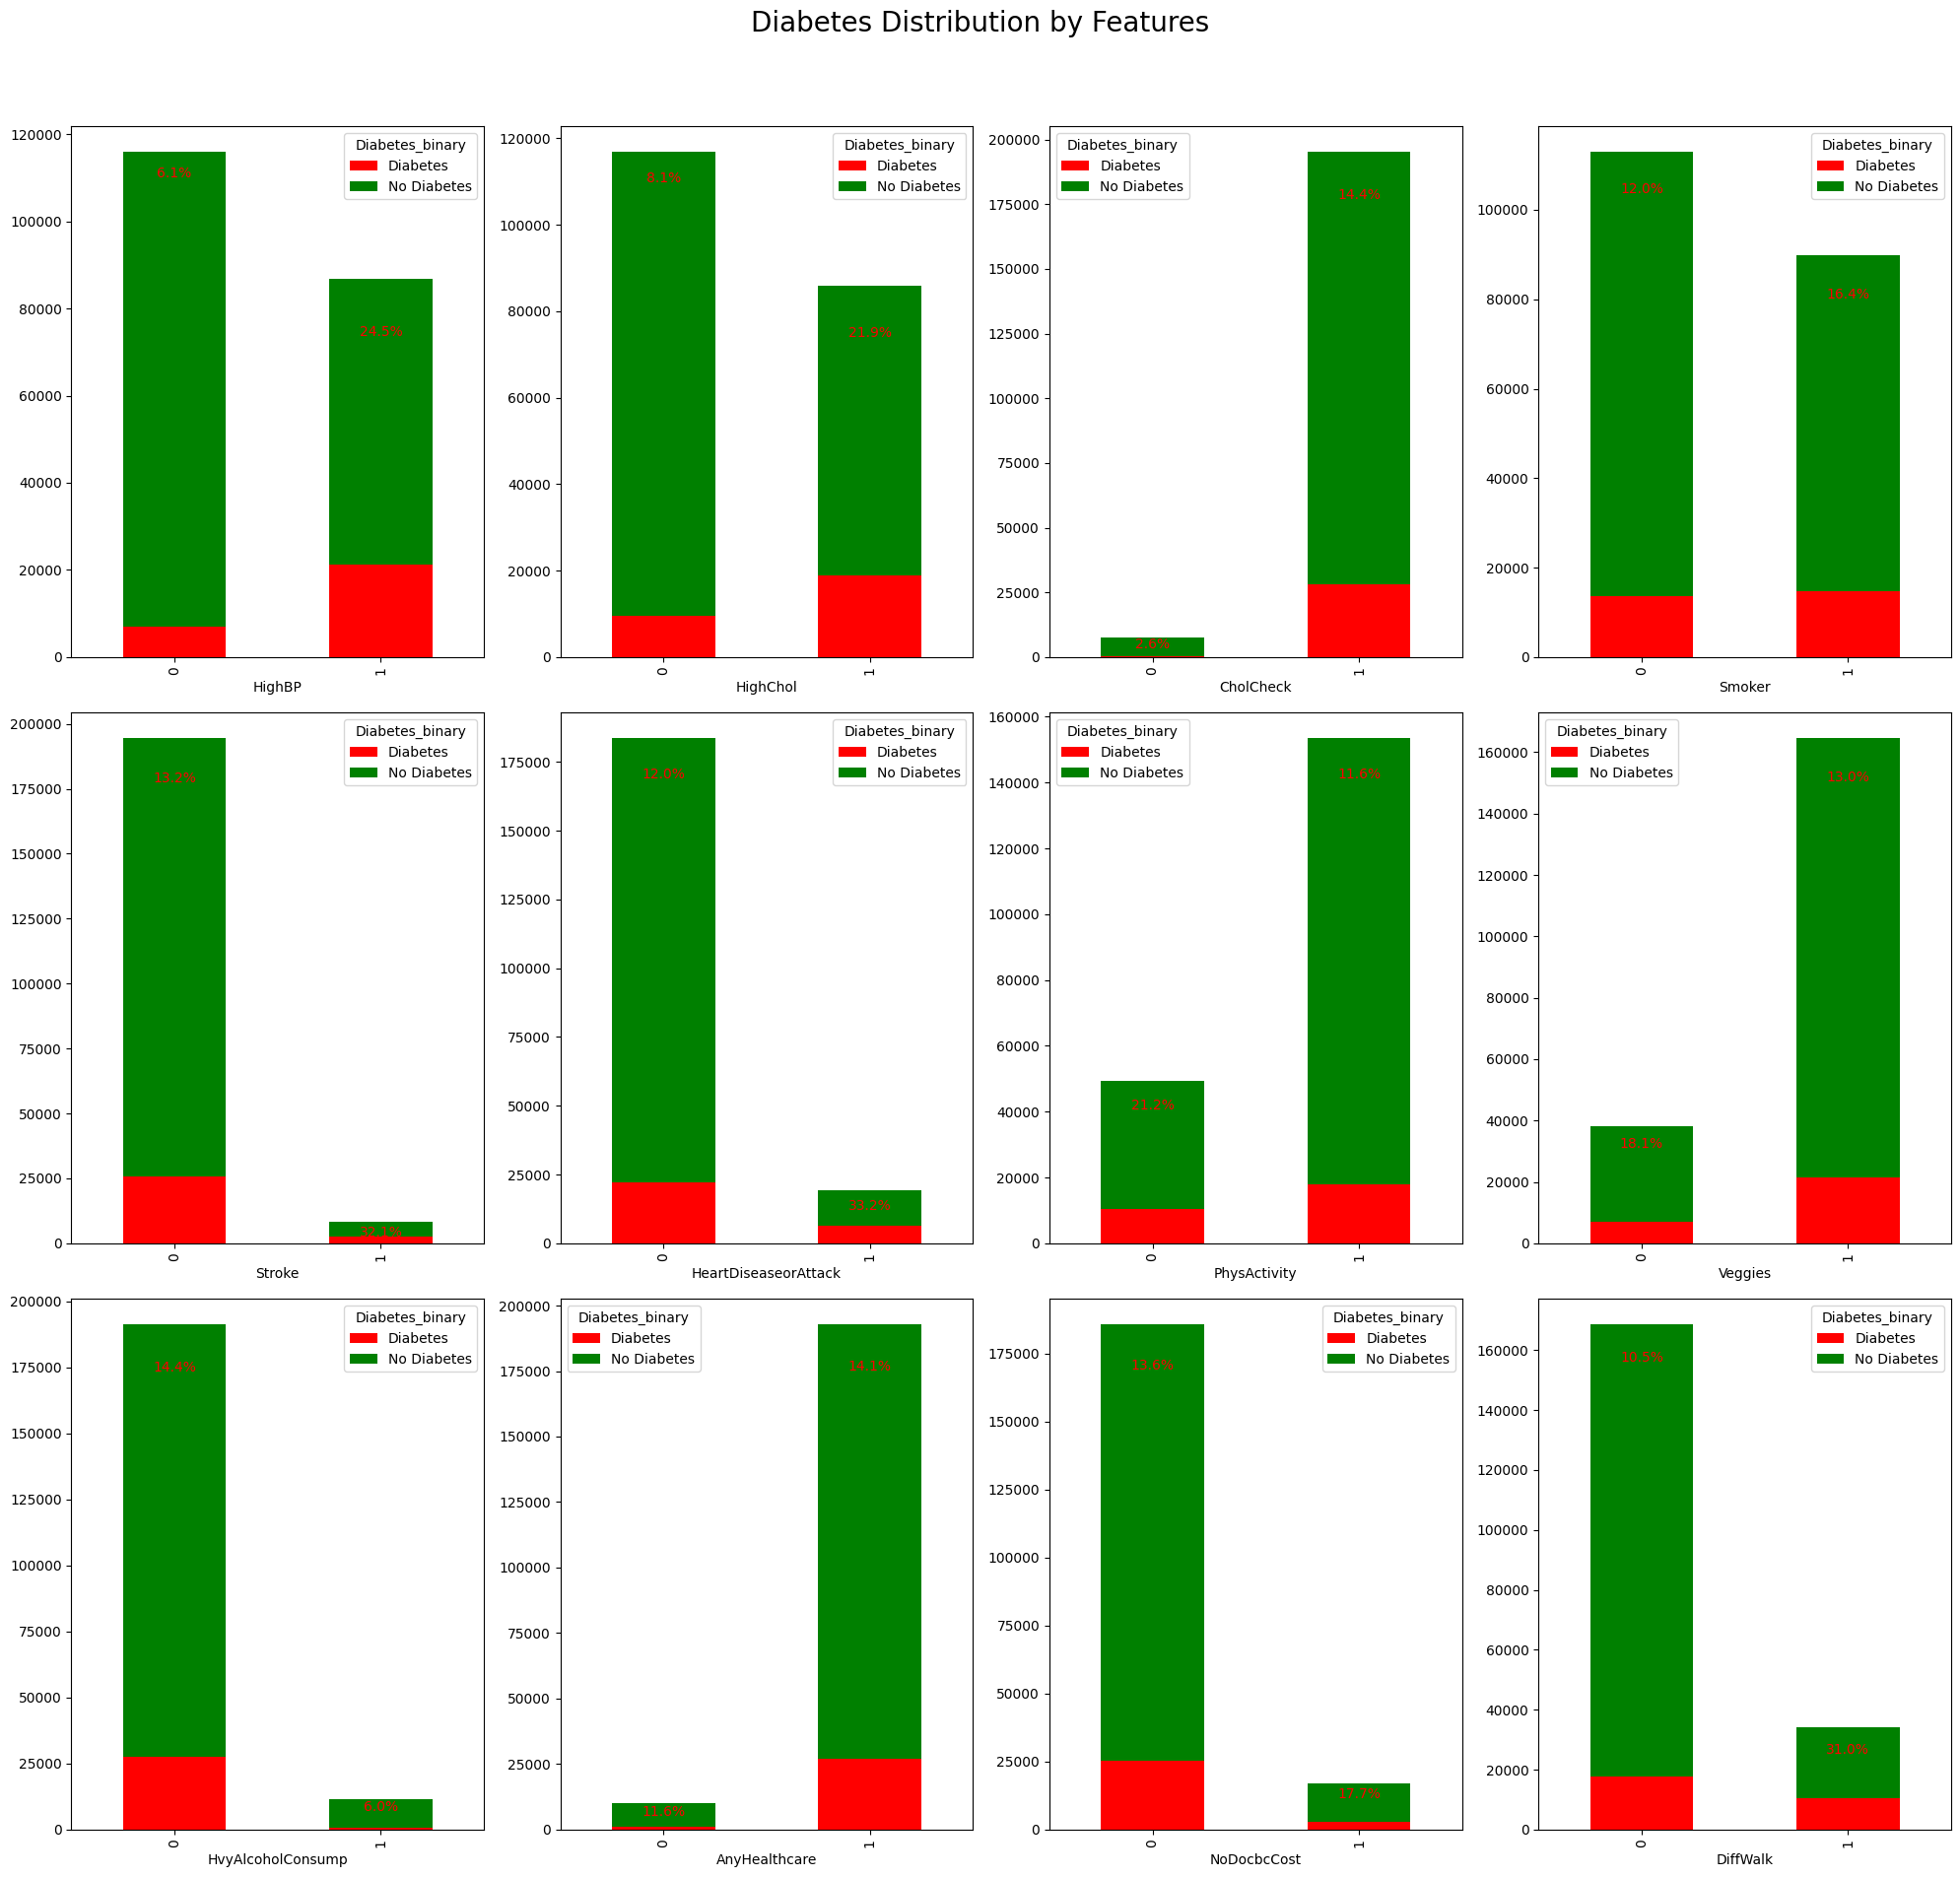

In [5]:
cols = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 
        'PhysActivity', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk']

def create_plot_pivot(data, x_column):
    """Create a pivot table for satisfaction versus another rating for easy plotting."""
    # Merge `X` and `y` to ensure access to 'Diabetes_binary' column for grouping
    data_with_target = data.copy()
    data_with_target['Diabetes_binary'] = y['Diabetes_binary']
    data_with_target['Diabetes_binary'] = data_with_target['Diabetes_binary'].replace({0: 'No Diabetes', 1: 'Diabetes'})
    
    _df_plot = data_with_target.groupby([x_column, 'Diabetes_binary']).size() \
                   .reset_index().pivot(columns='Diabetes_binary', index=x_column, values=0)
    return _df_plot

fig, ax = plt.subplots(3, 4, figsize=(20, 20))
axe = ax.ravel()
c = len(cols)
plt.suptitle('Diabetes Distribution by Features', fontsize=20)

# Custom colors for the plot
custom_colors = {'No Diabetes': 'green', 'Diabetes': 'red'}

# Plotting each column in cols
for i in range(c):
    plot_data = create_plot_pivot(X, cols[i])
    plot_data.plot(kind='bar', stacked=True, ax=axe[i], color=[custom_colors[val] for val in plot_data.columns])
    axe[i].set_xlabel(cols[i])
    
    # Adding percentage labels for the "Diabetes" (red) part of each bar
    for j, (index, row) in enumerate(plot_data.iterrows()):
        total = row['No Diabetes'] + row['Diabetes']  # Sum of "No Diabetes" and "Diabetes" counts
        if total > 0:
            diabetes_percentage = (row['Diabetes'] / total) * 100  # Calculate percentage for Diabetes
            axe[i].text(j, row['No Diabetes'] + row['Diabetes'] / 2, 
                        f"{diabetes_percentage:.1f}%", color="red", ha="center", va="top")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
plt.show()


#### Gaussian distribution

In [6]:

def normal_probability_plot(data, col):
    """
    Generates a normal probability plot for the given data.
    
    Parameters:
        data (array-like): The data for which to generate the plot.
        
    Returns:
        None
    """
    # Generate a probability plot
    stats.probplot(data, dist="norm", plot=plt)
    plt.title("Normal Probability Plot for "+ col)
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.show()

In [ ]:
# for col in X.columns:
#     normal_probability_plot(X[col], col)

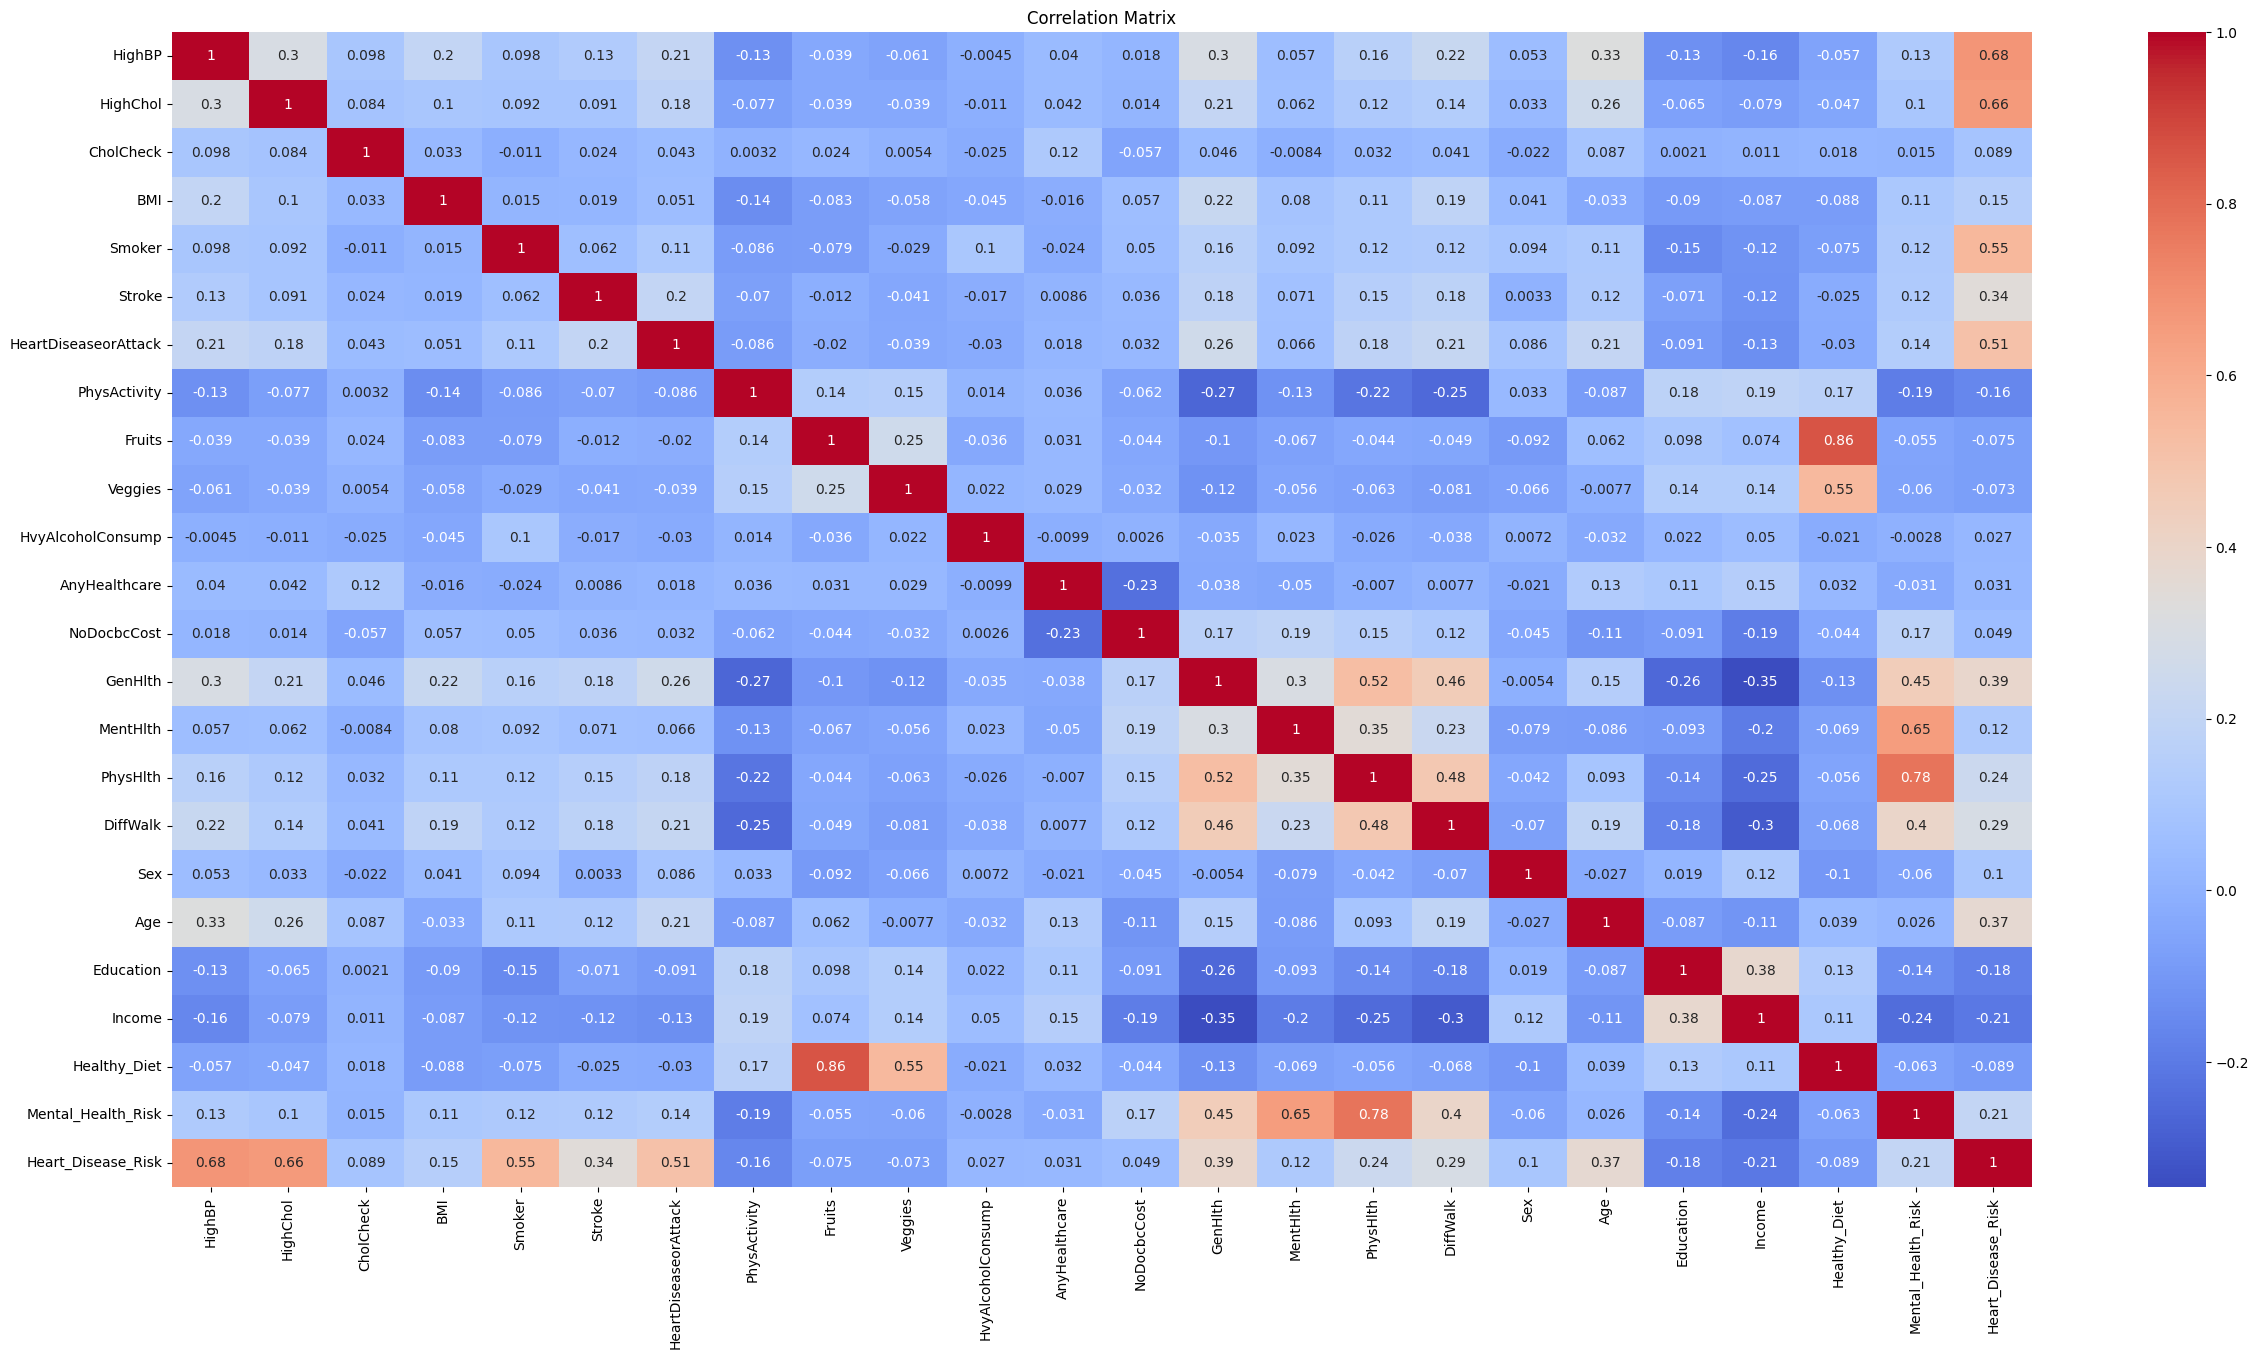

In [9]:
#Correlation matrix

corr = X.select_dtypes(include=[float, int]).corr()
plt.figure(figsize=(30, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Process the data

In [ ]:

# Look for multicollinearity between the features and remove the features that are unnecessary
# we already know the age so age_group is not needed
columnsToDrop = ['Age_Group', 'MentHlth', 'HvyAlcoholConsump', 'NoDocbcCost', 'Smoker', 'Fruits', 'Mental_Health_Risk', 'Education', 'Income', 'Heart_Disease_Risk']
X = X.drop(columns=columnsToDrop)
X = feature_encoding(X)

X_testing = X_testing.drop(columns=columnsToDrop)
X_testing = feature_encoding(X_testing)

X_testing.head()

### Split validation set and train set

In [ ]:
from training import *
is_equal_classes = False

In [ ]:
# Basic splits of the data
X_train, X_validation, y_train, y_validation =  data_splits(X, y) #   split data
is_equal_classes = False
X_train_scaled, X_validation_scaled, X_testing_Scaled = normalize_features(X_train, X_validation, X_testing) #   normalize data


In [ ]:
# # Equal classes splits of the data
# X_train, X_validation, y_train, y_validation =  data_splits_equal_classes(X, y) #   split data into equal classes. Meaning there is as many diabetes as non diabetes. But we remove some data
# is_equal_classes = True
# X_train_scaled, X_validation_scaled, X_testing_Scaled = normalize_features(X_train, X_validation, X_testing) #   normalize data

### Training

In [ ]:
import numpy as np
from sklearn.utils import gen_batches
def predict_in_batches(cls, X, batch_size=100):
    """
    Make predictions for the input data in batches.
    
    Parameters:
        cls (object): The trained classifier model.
        X (array-like): The input data to make predictions for.
        batch_size (int): The size of each batch.
        
    Returns:
        array-like: The predictions for the input data.
    """
    predictions = []
    
    # Generate batches and make predictions for each batch
    for batch in gen_batches(len(X), batch_size):
        batch_predictions = cls.predict(X[batch])
        predictions.append(batch_predictions)
    
    # Concatenate all batch predictions into a single array
    predictions = np.concatenate(predictions, axis=0)
    return predictions

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def perform_grid_search(model, X_train_scaled, y_train, params):
    print("Performing grid search for ", model)
    # Define the cross-validation strategy
    strat_kfold = StratifiedKFold(n_splits=10) # TODO

    # Grid search for the model 
    #"f1_macro": Calculates F1-score per class and takes the average, treating all classes equally.
    #"f1_weighted": Calculates F1-score per class and takes a weighted average, considering class imbalance.
    grid_search = GridSearchCV(model, params, scoring='f1', cv=strat_kfold, n_jobs=10) # n_jobs=10 uses 10 parallel processes. Speeds up the process 


    if isinstance(model, RandomForestClassifier) or isinstance(model, SVC):
        grid_search.fit(X_train_scaled, y_train.values.ravel())
    else:
        grid_search.fit(X_train, y_train)
    best_param = grid_search.best_params_
    best_score = grid_search.best_score_ 
    print("Best parameters are:", best_param)
    print("Best score is:", best_score)

    # Return the fitted grid search objects
    # return grid_search, best_param, best_score

In [ ]:
def model_training(model, X_train_scaled, y_train, X_validation_scaled, y_validation):
    model.fit(X_train_scaled, y_train)
    y_validation_pred = model.predict(X_validation_scaled)
    validation_f1 = f1_score(y_validation, y_validation_pred)
    print("Validation f1 score:", validation_f1)
    print(classification_report(y_validation, y_validation_pred))

In [ ]:
def classification_summary(y_train, y_train_pred, y_validation, y_validation_pred):
    train_f1 = f1_score(y_train, y_train_pred) 
    validation_f1 = f1_score(y_validation, y_validation_pred) 
    print("Train f1 score:", train_f1)

    print("Validation f1 score:", validation_f1)
    print("\nTraining Set Classification Report:")

    print(classification_report(y_train, y_train_pred))

    print("Training Set Confusion Matrix:")

    print(confusion_matrix(y_train, y_train_pred))

    print("\nValidation Set Classification Report:")

    print(classification_report(y_validation, y_validation_pred))

    print("Validation Set Confusion Matrix:")

    print(confusion_matrix(y_validation, y_validation_pred))

In [ ]:
def classification_summary_one( y_validation, y_validation_pred):
    validation_f1 = f1_score(y_validation, y_validation_pred) 
    print("Validation f1 score:", validation_f1)
    print("\nValidation Set Classification Report:")

    print(classification_report(y_validation, y_validation_pred))

    print("Validation Set Confusion Matrix:")

    print(confusion_matrix(y_validation, y_validation_pred))

In [ ]:
def kaggle_submission(model, X_testing_scaled, x_testing_id):
    y_pred = model.predict(X_testing_scaled)
    y_pred = pd.DataFrame({
        'index': x_testing_id , 
        'Diabetes_binary': y_pred,
    })

    # Save the predictions to a CSV file
    y_pred.to_csv(f'./{model}_y_pred.csv', index=False)

In [ ]:
def submission_pred(model, X_testing_scaled):
    return model.predict(X_testing_scaled)


def submission_proba(model, X_testing_scaled):
    return model.predict_proba(X_testing_scaled)[:, 1]

### Random Forest

In [ ]:
############### TESTING ####################
from sklearn.ensemble import RandomForestClassifier


cls_randomforest = RandomForestClassifier(class_weight='balanced', 
                                          random_state=42, 
                                          max_depth=20, 
                                          max_leaf_nodes=200, 
                                          min_samples_leaf=20, n_estimators=500)

param_grid_random_forest = {
    'n_estimators': [10, 200, 300, 400, 500, 1000, 5000],
    'max_depth': [20, 30],
    'bootstrap': [True, False],
}
perform_grid_search(cls_randomforest, X_train_scaled, y_train, params= param_grid_random_forest)




In [ ]:
if is_equal_classes:
    print('Equal classes')
    cls_randomforest = RandomForestClassifier(class_weight='balanced',
                                          random_state=42, 
                                          max_depth=20, 
                                          max_leaf_nodes=200, 
                                           n_estimators=1000) #min_samples_leaf=20
else:
    cls_randomforest = RandomForestClassifier( class_weight={0: 1, 1: 3}, # class_weight='balanced',
                                            random_state=42, 
                                            max_depth=20, 
                                            max_leaf_nodes=200, 
                                            n_estimators=1000) #min_samples_leaf=20

model_training(cls_randomforest, X_train_scaled, y_train, X_validation_scaled, y_validation)

In [ ]:
y_train_pred = predict_in_batches(cls_randomforest, X_train_scaled)
y_validation_pred = predict_in_batches(cls_randomforest, X_validation_scaled)

In [ ]:
classification_summary(y_train, y_train_pred, y_validation, y_validation_pred)

### Random Forest with PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=12)#n_components=2
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
cls_randomforest_pca = RandomForestClassifier(class_weight='balanced', random_state=42, max_depth=20, max_leaf_nodes=200, n_estimators=1000)
model_training(cls_randomforest_pca, X_train_pca, y_train, pca.transform(X_validation_scaled), y_validation)


### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

cls_decision_tree = DecisionTreeClassifier(max_depth=5)


param_grid_decision_tree = {
    'criterion': ['gini','entropy'],
    'max_depth': [10, 20, 50],
    'min_samples_leaf': [2, 3, 10],
    'max_leaf_nodes': [5, 10, 50]
}

perform_grid_search(cls_decision_tree, X_train_scaled, y_train, params=param_grid_decision_tree)


In [ ]:
cls_decision_tree = DecisionTreeClassifier(criterion='gini', class_weight={0: 1, 1: 3}, max_depth=10, min_samples_leaf=2, max_leaf_nodes=10)
model_training(cls_decision_tree, X_train_scaled, y_train, X_validation_scaled, y_validation)

### Decision Tree with Bagging

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

cls_decision_tree = DecisionTreeClassifier(class_weight={0: 1, 1: 3}, criterion='gini', max_depth=10, min_samples_leaf=2, max_leaf_nodes=10)
bagging_model = BaggingClassifier(estimator=cls_decision_tree, n_estimators=50, random_state=42)
model_training(bagging_model, X_train_scaled, y_train, X_validation_scaled, y_validation)

### Decision Tree with Adaboosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Set up a decision stump as the weak learner
base_estimator = DecisionTreeClassifier(max_depth=1, class_weight={0: 1, 1: 3}, criterion='gini')  # Decision stump class_weight='balanced'

# Create an AdaBoost classifier using the decision tree as the base estimator
ada_boost = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)

# Assuming `model_training` is a function that trains and evaluates the model
model_training(ada_boost, X_train_scaled, y_train, X_validation_scaled, y_validation)


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
cls_logistic = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000, dual=False, C=5)
param_grid_logistic = {
    'max_iter':[1000, 2000, 3000],
    'tol': [1e-3, 1e-4, 1e-5],
    'C': [0.5, 1, 10],
}
perform_grid_search(cls_logistic, X_train_scaled, y_train, param_grid_logistic)

In [ ]:
### Use best parameters to train the model
if is_equal_classes:
    print('Equal classes')
    cls_logistic = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000, dual=False, C=1, tol=1e-3)
else:
    cls_logistic = LogisticRegression(random_state=42, class_weight={0: 1, 1: 4}, max_iter=1000, dual=False, C=1, tol=1e-3)
model_training(cls_logistic, X_train_scaled, y_train, X_validation_scaled, y_validation)

### Logistic Regression with Adaboosting

In [ ]:
# Initialize logistic regression as the base estimator
cls_logistic_regiression = LogisticRegression(random_state=42, class_weight={0: 1, 1: 4}, max_iter=1000, dual=False, C=1, tol=1e-3)

# Create an AdaBoost classifier using logistic regression as the base estimator
ada_boost = AdaBoostClassifier(estimator=cls_logistic_regiression, n_estimators=50, learning_rate=1.0, random_state=42)

model_training(ada_boost, X_train_scaled, y_train, X_validation_scaled, y_validation)

### XGBClassifier

In [ ]:
from xgboost import XGBClassifier

In [ ]:
# Initialize the XGBoost classifier
# booster [default= gbtree ]
# Which booster to use. Can be gbtree, gblinear or dart; gbtree and dart use tree based models while gblinear uses linear functions.
xgb_model = XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='logloss') # binary:hinge

# Define the parameter grid
param_grid = {
    'eval_metric': ['error', 'logloss', 'auc'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['error'],
    'n_estimators': [50, 100, 200, 5000],
    'max_depth': [3, 5, 7]
}
perform_grid_search(xgb_model, X_train_scaled, y_train, param_grid)

In [ ]:
xgb_model = XGBClassifier(random_state=42, max_depth=7,  objective='binary:logistic', eval_metric='error', booster='gbtree', n_estimators=5000)
model_training(xgb_model, X_train_scaled, y_train, X_validation_scaled, y_validation)

### SVM

In [ ]:
cls_svm = SVC(class_weight='balanced', random_state=42, kernel='rbf', C=1)
param_grid_svm = {
    'kernel':['rbf', 'sigmoid'],
    'shrinking': [True],
    'C': [1, 10],
}
perform_grid_search(cls_svm, X_train_scaled, y_train, param_grid_svm)

In [ ]:
cls_svm = SVC(class_weight='balanced', random_state=42, kernel='rbf', C=1, shrinking=True)
model_training(cls_svm, X_train_scaled, y_train, X_validation_scaled, y_validation)

### K-NN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
param_grid_svm = {
    'weights':['distance', 'uniform', None],
    'leaf_size': [10, 30, 50],
}
cls_knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
perform_grid_search(cls_knn, X_train_scaled, y_train, param_grid_svm)

In [ ]:
cls_knn = KNeighborsClassifier(n_neighbors=5,  weights='distance', algorithm='auto', leaf_size= 10)
model_training(cls_knn, X_train_scaled, y_train, X_validation_scaled, y_validation)

### Bagging

In [ ]:
# Make predictions on the testing or validation data
pred_array = []
for model in [cls_randomforest, cls_logistic, bagging_model, ada_boost]:#xgb_model
    pred_array.append(submission_pred(model, X_testing_Scaled))

# Take the majority vote
pred_array = np.array(pred_array)
for i in range(len(pred_array[0])):
    if sum([pred[i] for pred in pred_array]) >= pred_array.shape[0] / 2:
        pred_array[0][i] = 1
    else:
        pred_array[0][i] = 0

# classification_summary_one(y_validation, pred_array[0])
# Save the predictions to a CSV file
y_pred = pd.DataFrame({
    'index': x_testing_id , 
    'Diabetes_binary': pred_array[0],
})
y_pred.to_csv('./y_pred.csv', index=False)

In [ ]:
prob_array = []
for model in [cls_randomforest, cls_logistic, xgb_model, bagging_model, ada_boost]:
    prob_array.append(submission_proba(model, X_validation_scaled))

# Take most confident prediction
prob_array = np.array(prob_array)
for i in range(len(prob_array[0])):
    if sum([prob[i] for prob in prob_array]) >= 2.3: # best is either 1.3 or 1.4 considering 3 models
        prob_array[0][i] = 1
    else:
        prob_array[0][i] = 0
pred_array = prob_array[0].astype(int)
classification_summary_one(y_validation, pred_array)

### Hybrid Bagging

In [ ]:
pred_array = []
for model in [cls_randomforest, cls_logistic, xgb_model, bagging_model, ada_boost]:
    pred_array.append(submission_pred(model, X_validation_scaled))

prob_array = []
for model in [cls_randomforest, cls_logistic, xgb_model, bagging_model, ada_boost]:
    prob_array.append(submission_proba(model, X_validation_scaled))

# Take the majority vote
pred_array = np.array(pred_array)
for i in range(len(pred_array[0])):
    if sum([pred[i] for pred in pred_array]) >= pred_array.shape[0] / 2 or sum([prob[i] for prob in prob_array]) >= 3.0: # logistic has been train on a equal class dataset. This is an experiment
        pred_array[0][i] = 1
    else:
        pred_array[0][i] = 0

classification_summary_one(y_validation, pred_array[0])

### Bagging + PCA models

In [ ]:
pred_array = []

for model in [cls_randomforest, cls_logistic, bagging_model, ada_boost]:#xgb_model
    pred_array.append(submission_pred(model, X_validation_scaled))

for pca_model in [cls_randomforest_pca]:
    pred_array.append(submission_proba(pca_model, pca.transform(X_validation_scaled)))

# Take the majority vote
pred_array = np.array(pred_array)
for i in range(len(pred_array[0])):
    if sum([pred[i] for pred in pred_array]) >= pred_array.shape[0] / 2:
        pred_array[0][i] = 1
    else:
        pred_array[0][i] = 0

classification_summary_one(y_validation, pred_array[0])